## Обзор реестра ЦЭИЗ (Государственный реестр лекарственных средств Республики Беларусь)

### Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud
from pandas_profiling import ProfileReport
from collections import Counter
from datetime import timedelta

### Чтение, обзор данных


In [2]:
df = pd.read_csv('rceth.csv') # датасет с данными из реестра
ATC = pd.read_csv('ATC.csv').iloc[:, [0, 1]] # датасет с кодами АТХ и их расшифровкой

In [3]:
df = df[['ATC_code', 'trade_name', 'international_name', 'dosage_form', 'manufacturer', 'applicant', 'prescribed', 'original', 'storage_list', 'term_of_usage', 'registration_date']]
df.head(3)

ATC_code     trade_name international_name  \
0  B05AA01       АЛЬБУМИН            Albumin   
1  J01XA01  ВАНКОМИЦИН-ТФ         Vancomycin   
2  A06AG02      БИСАКОДИЛ          Bisacodyl   

                                         dosage_form  \
0  раствор для инфузий 100мг/мл в бутылках стекля...   
1  порошок для приготовления раствора для инфузий...   
2  суппозитории ректальные 10мг в контурной ячейк...   

                                        manufacturer  \
0  Государственное учреждение Республиканский нау...   
1               ТрайплФарм СООО, Республика Беларусь   
2                  Farmaprim SRL, Республика Молдова   

                                           applicant       prescribed  \
0  Государственное учреждение Республиканский нау...  для стационаров   
1               ТрайплФарм СООО, Республика Беларусь       по рецепту   
2                  Farmaprim SRL, Республика Молдова      без рецепта   

       original storage_list term_of_usage registration_date  
0  оригинальное          NaN        3 года        20.12.2018  
1       генерик          NaN        3 года        06.07.2020  
2       генерик          NaN        3 года        21.11.2018

In [4]:
df.dtypes

ATC_code              object
trade_name            object
international_name    object
dosage_form           object
manufacturer          object
applicant             object
prescribed            object
original              object
storage_list          object
term_of_usage         object
registration_date     object
dtype: object

In [5]:
profile = ProfileReport(df, title='Profile Report')

In [6]:
#profile

### Processing, Feautue engineering

#### Измение регистра торгового наименования, изменение формата данных

In [7]:
df.trade_name = df.trade_name.str.capitalize()
df.registration_date = pd.to_datetime(df.registration_date, format="%d.%m.%Y", exact=True)

In [8]:
def time_to_day(usage_time):
    try:
        usage = usage_time.split()
        if 'года' in usage or 'лет' in usage or 'год' in usage or len(usage) == 1:
            delta = float(usage[0]) * 365
        elif 'мес.' in usage:
            delta =  float(usage[0]) * 30.4167
        elif 'суток' in usage or 'день' in usage:
            delta = float(usage[0])
        elif 'часов' in usage:
            delta = float(usage[0]) / 24
        else:
            return usage[0]

        return timedelta(days=delta).days
    
    except AttributeError:
        return np.nan

In [9]:
df.term_of_usage = df.term_of_usage.replace(',', '.', regex=True)
df.term_of_usage = df.term_of_usage.apply(time_to_day)

#### Создание новой колонки "импорт"
Так как количество производителей может быть несколько для одного препарата, то для простоты буду считать, что если среди производителей есть Республика Беларусь, то лекарственный препарат произведен в Беларуси

In [11]:
df['is_import'] = df.manufacturer.str.split('/').apply(lambda x: [i.split(', ')[-1].strip() for i in x])\
    .apply(lambda x: 0 if 'Республика Беларусь' in x else 1)

#### Создание новой колонки "Лекарство"

In [12]:
df['is_lp'] = df.ATC_code.apply(lambda x: 0 if x is np.nan else 1)

#### Создание новой колонки с упрощенной лекарственной формой (требует доработки)

In [13]:
df['form'] = df.dosage_form.replace(',', '', regex=True).str.split().apply(lambda x: x[0])

#### Создание новых колонок с 1ым и 2ым уровнем по АТХ классификации

In [14]:
df['ATC_first'] = df.ATC_code.apply(lambda x: x if x is np.nan else ATC.loc[ATC.atc_code==x[0], 'atc_name'].values[0]).str.lower()
df['ATC_second'] = df.ATC_code.apply(lambda x: x if x is np.nan else ATC.loc[ATC.atc_code==x[0:3], 'atc_name'].values[0]).str.lower()

#### Изменение порядка отпуска у одного препарата для удобства

In [15]:
df.loc[df.prescribed == 'без рецепта, по рецепту(100мл)', 'prescribed'] = 'без рецепта'

### Выборка датасетов для дальнейшего анализа

In [16]:
lp_sub = df[['trade_name', 'international_name', 'form', 'is_import', 'is_lp', 
         'prescribed', 'original', 'storage_list', 'term_of_usage', 
         'registration_date', 'ATC_first', 'ATC_second']]  # лекарства и субстанции
lp = lp_sub.loc[lp_sub.is_lp == 1] # только лекарства

lp_sub.head()

trade_name        international_name          form  is_import  is_lp  \
0       Альбумин                   Albumin       раствор          0      1   
1  Ванкомицин-тф                Vancomycin       порошок          0      1   
2      Бисакодил                 Bisacodyl  суппозитории          1      1   
3          Аевит  Combinations of vitamins       капсулы          0      1   
4     Гентамицин                Gentamicin          мазь          0      1   

        prescribed      original storage_list  term_of_usage  \
0  для стационаров  оригинальное          NaN         1095.0   
1       по рецепту       генерик          NaN         1095.0   
2      без рецепта       генерик          NaN         1095.0   
3       по рецепту       генерик          NaN          730.0   
4       по рецепту       генерик          NaN         1095.0   

  registration_date                        ATC_first  \
0        2018-12-20   blood and blood forming organs   
1        2020-07-06  antiinfectives for systemic use   
2        2018-11-21  alimentary tract and metabolism   
3        2018-03-29  alimentary tract and metabolism   
4        2020-03-17                  dermatologicals   

                                          ATC_second  
0          blood substitutes and perfusion solutions  
1                    antibacterials for systemic use  
2                             drugs for constipation  
3                                           vitamins  
4  antibiotics and chemotherapeutics for dermatol...

### Визуализация и анализ
#### Соотношение лекарственных препаратов и субстанций

In [17]:
a = lp_sub.is_lp.value_counts()
fig = px.pie(values=a, names = ['ЛП', 'Субстанции'], title='Соотношение лекарственных препаратов и субстанций', hole=0.5)
fig.show()

В реестре ЦЭИЗ лекарственых препаратов 3/4 от общего количества

### Наиболее часто встречающиеся МНН

In [18]:
mnn_and_count = lp.loc[:, ['trade_name', 'international_name']]\
    .groupby(['international_name']).count().reset_index()\
    .rename(columns={'trade_name': 'count'}).sort_values('count', ascending = False)[0:15]
fig = px.bar(mnn_and_count, x='international_name', y='count', title="Наиболее часто встечающиеся МНН",
            labels={'count':'Количество', 'international_name' : 'МНН'})
fig.show()

(-0.5, 1999.5, 999.5, -0.5)

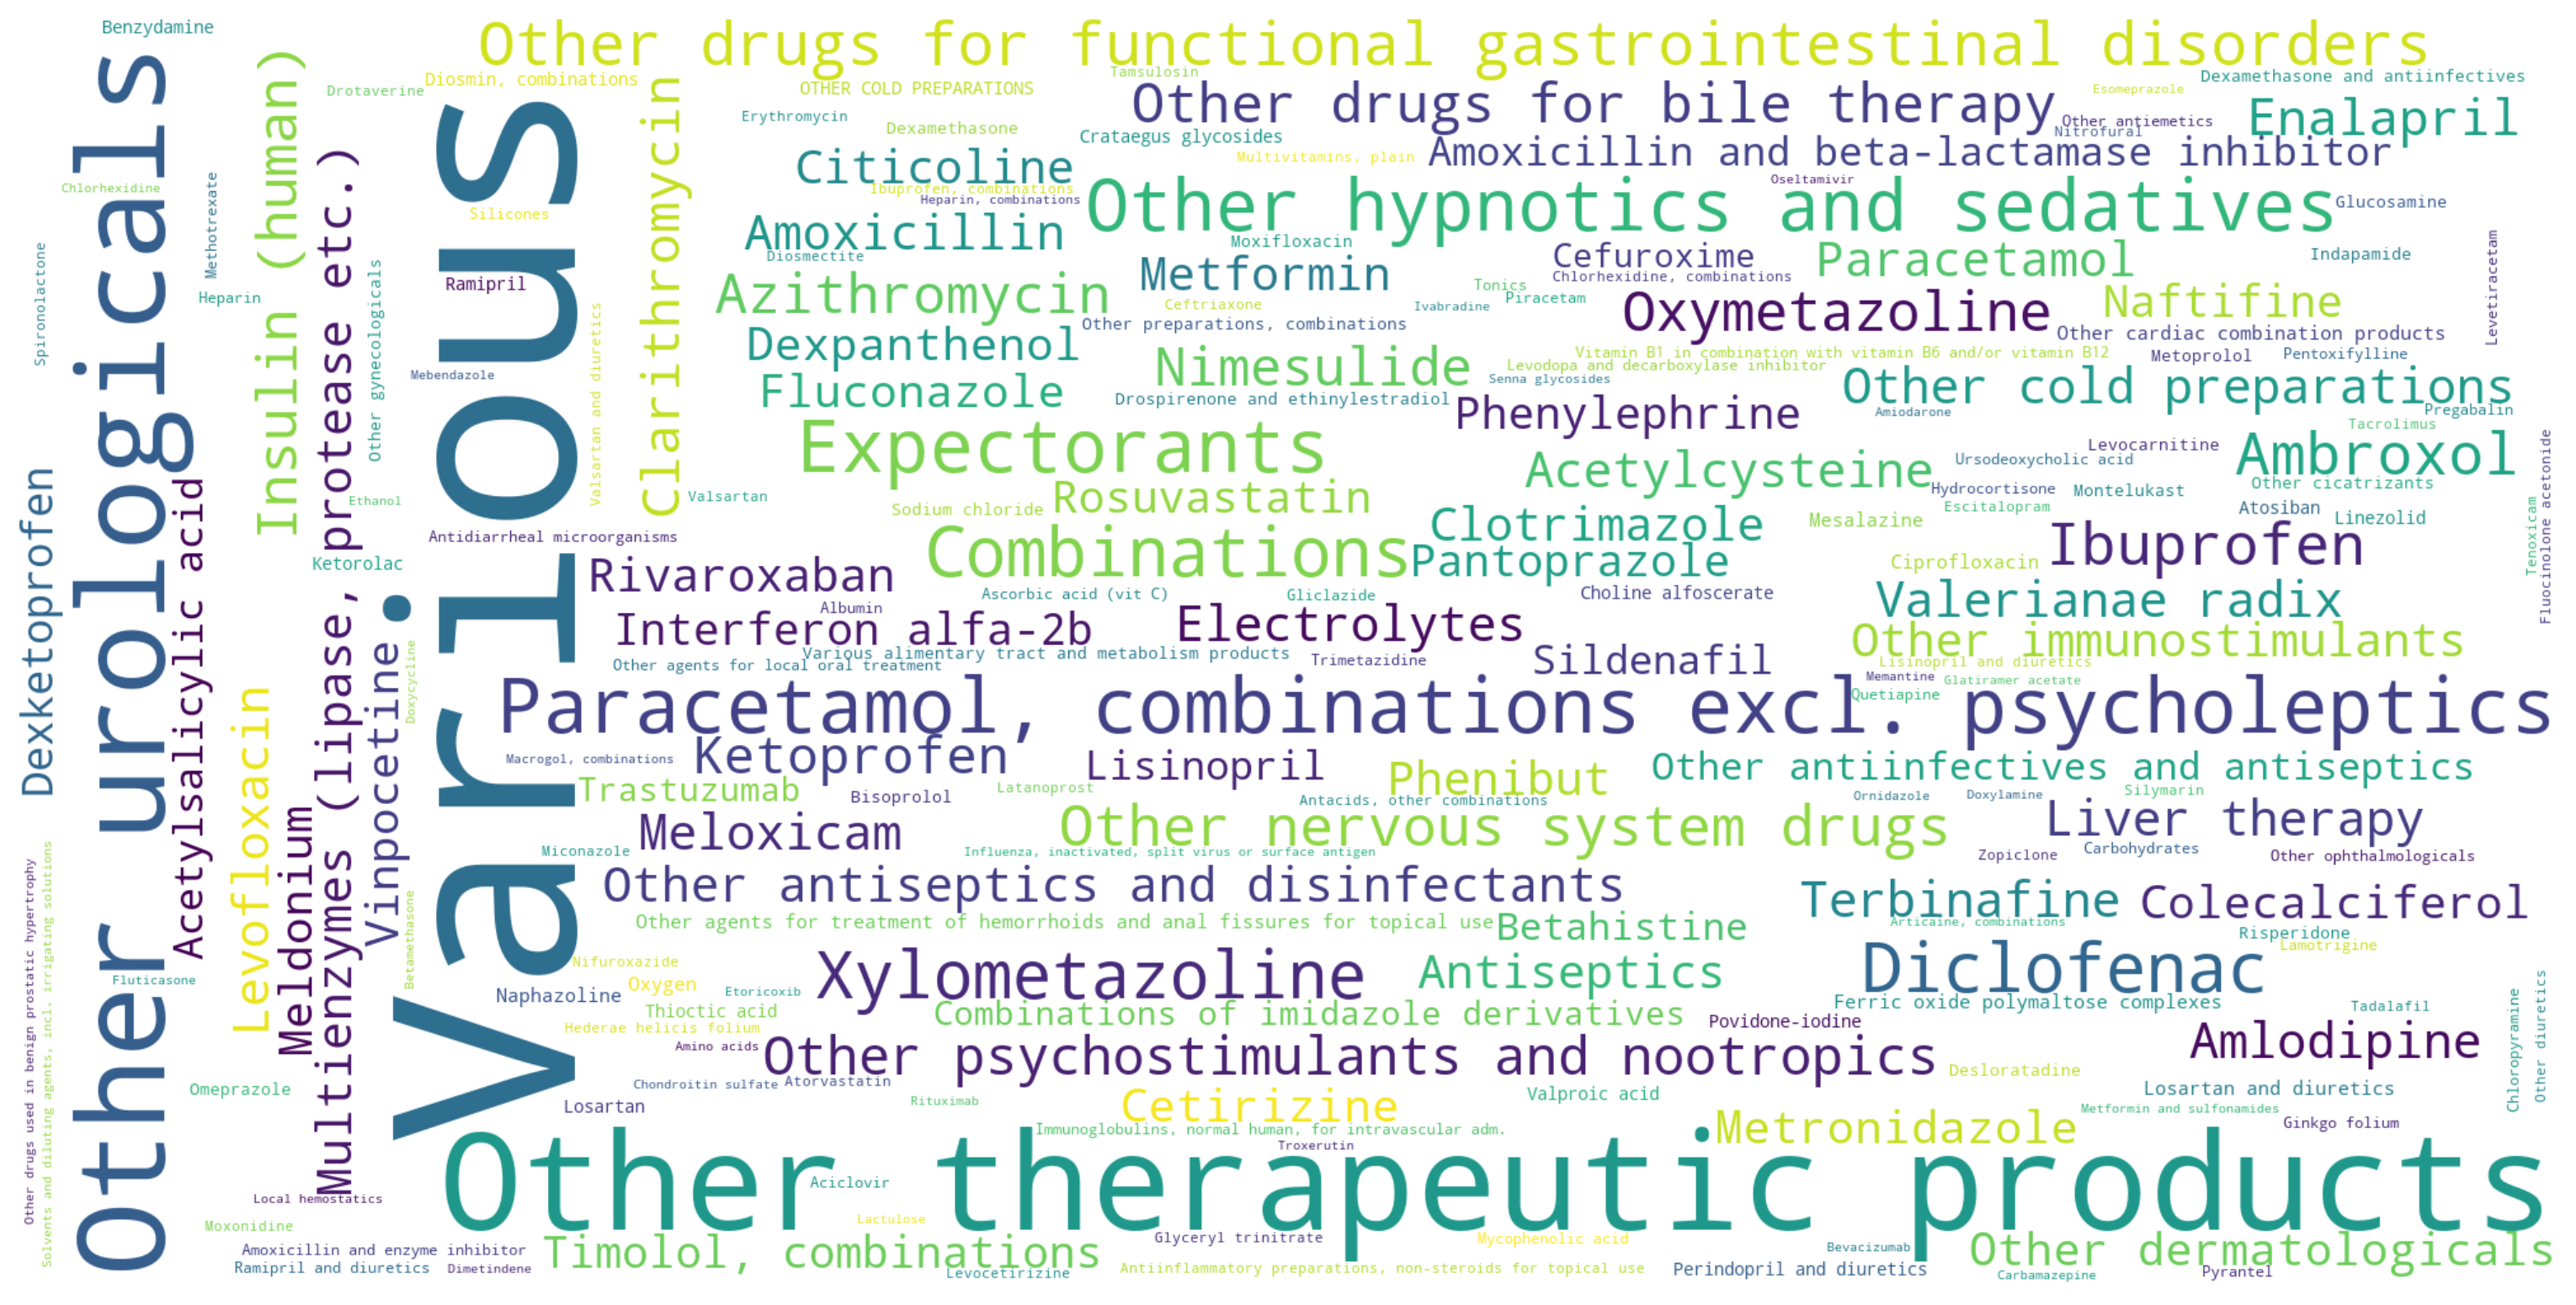

In [19]:
dictionary=Counter(lp.international_name.to_numpy())
wc = WordCloud(background_color="white", width=2000, height=1000)
wc.generate_from_frequencies(dictionary)
plt.figure(figsize=(20,10), dpi=200)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")

Наиболее часто встречаются лекарственные препараты без определенного МНН и отнесенные в более общую группу. Кроме них, самыми популярными являются Диклофенак, Ксилометазолин, Амброксол, Ибупрофен

### Наиболее часто встречающиеся ЛФ

In [20]:
lf_and_count = lp.loc[:, ['trade_name', 'form']]\
    .groupby(['form']).count().reset_index()\
    .rename(columns={'trade_name': 'count'}).sort_values('count', ascending = False)[0:15]

fig = px.bar(lf_and_count, x='form', y='count', title="Наиболее часто встечающиеся ЛФ",
            labels={'count':'Количество', 'form' : 'ЛФ'})
fig.show()

Наиболее популярными являются таблетки, капсулы, растворы в совокупности

### Распределение лекарственных препаратов по фармакологической группе

In [21]:
fg_and_count = lp.loc[:, ['trade_name', 'ATC_first']]\
    .groupby(['ATC_first']).count().reset_index()\
    .rename(columns={'trade_name': 'count'}).sort_values('count', ascending = False)[0:15]

fig = px.pie(fg_and_count, values='count', names = 'ATC_first', title='Распределение лекарственных препаратов по фармакологической группе (уровень 1 по АТХ)')
fig.show()

Больше всего лекарственных препаратов зарегистрировано для ЖКТ и метаболизма, после них идут ЛП для нервной системы и кардиоваскулярной системы.

In [22]:
fg_and_count2 = lp.loc[:, ['trade_name', 'ATC_first', 'ATC_second']]\
    .groupby(['ATC_first', 'ATC_second']).count().reset_index()\
    .rename(columns={'trade_name': 'count'})
    
fig = px.bar(fg_and_count2, x="ATC_first", y="count", color="ATC_second", 
             title = 'Распределение лекарственных препаратов по фармакологической группе (уровень 1 и 2 по АТХ)',
             labels={'count':'Количество', 'ATC_first' : 'АТХ (1 уровень)', 'ATC_second' : 'АТХ (2 уровень)'})

fig.update_layout(
    autosize=False,
    width=950,
    height=800,)

fig.show()

На данной диаграмме можно посмотреть соотношение количества ЛП определенной фармакологической группы АТХ 2 уровня к АТХ 1 уровня

### Соотношение лекарственных препаратов по критерию оригинальности

In [23]:
or_and_count = lp.loc[:, ['trade_name', 'original']]\
    .groupby(['original']).count().reset_index()\
    .rename(columns={'trade_name': 'count'}).sort_values('count', ascending = False)[0:15]

fig = px.pie(or_and_count, values='count', names = 'original', title='Соотношение лекарственных препаратов по критерию оригинальности', hole=0.5)
fig.show()

Около 1/4 всех лекарственных препаратов составляют оригинальные препараты. Доля генерических лекарственных средств больше 70%. Небольшую часть составляют биоаналоги и инновационные ЛП

### Соотношение лекарственных препаратов по порядку отпуска

In [24]:
otp_and_count = lp.loc[:, ['trade_name', 'prescribed']]\
    .groupby(['prescribed']).count().reset_index()\
    .rename(columns={'trade_name': 'count'}).sort_values('count', ascending = False)[0:15]

fig = px.pie(otp_and_count, values='count', names = 'prescribed', title='Соотношение лекарственных препаратов по поорядку отпуска', hole=0.5)
fig.show()

Около 60% ЛП относятся к безрецептурному отпуску, осталная часть к отпуску по рецепту или для стационаров. Однако я не уверен,что данная информация является верной, так как порядок отпуска в реестре ЦЭИЗ часто не соответствует постановлениям МЗ РБ, касающихся вопросов безрецептурного отпуска ЛП

### Соотношение лекарственных препаратов по списку хранения

In [25]:
st_and_count = lp.loc[:, ['trade_name', 'storage_list']]\
    .groupby(['storage_list']).count().reset_index()\
    .rename(columns={'trade_name': 'count'}).sort_values('count', ascending = False)[0:15]

st_and_count

storage_list  count
0              А     83
3   психотропное     19
1  наркотическое     12
2          общий      1

In [26]:
lp.loc[lp.storage_list == 'общий', :]

trade_name international_name form  is_import  \
4479  Кислород газообразный медицинский             Oxygen  газ          0   

      is_lp       prescribed original storage_list  term_of_usage  \
4479      1  для стационаров  генерик        общий          547.0   

     registration_date ATC_first                      ATC_second  
4479        2015-08-18   various  all other therapeutic products

Не буду комментировать данное соотношение различных списков хранения так как это вряд ли соответствует действительности. Выделю лишь "общий" список хранения, где присутствует только один препарат. Этим препаратом является "Кислород газообразный медицинский", почему для него выделили отдельную группу - неизвестно, почему у других медицинский газов нет такой группы (в том числе у кислорода) - неивестно. Еще одной странностью для этой позиции является то, что запись о нем в реестре появилась в 2021 или 2022 году, а на реестре дата регистрации указана - 18.08.2015 (препарат с самым ранним сроком регистрации)

### Распределение лекарственных препаратов по сроку годности

In [27]:
fig = px.histogram(lp, x="term_of_usage", title = 'Распределение лекарственных препаратов по сроку годности', nbins=13)

fig.update_layout(
    xaxis_title_text='Срок годности (дней)',
    yaxis_title_text='Количество')

fig.show()

#lp.loc[(lp.term_of_usage < 200) | (lp.term_of_usage > 2000), :]

Чаще всего лекарственные препараты регистрируются со сроком годности 3 и 2 года. Реже срок годности может быть 5 лет и 4 года, остальные случаи встречаются относительно редко.

Препараты со сроком годности 7 лет - Тамифлю, Реленза. К препаратам со сроками годности меньше 200 дней относятся радиофармацевтические препараты.

### Распределение лекарственных препаратов по дате их регистрации

In [28]:
reg_and_count = lp.loc[:, ['trade_name', 'registration_date']]\
    .groupby(['registration_date']).count().reset_index()\
    .rename(columns={'trade_name': 'count'})

fig = px.line(reg_and_count, x='registration_date', y='count', title='Распределение лекарственных препаратов по дате их регистрации')

fig.update_layout(
    xaxis_title_text='Дата регистрации',
    yaxis_title_text='Количество')
fig.update_xaxes(rangeslider_visible=True)

fig.show()

На графике видно что количество регистрируемых лекарственных препаратов имеет неравномерный характер. Наибольшее количество лекарственных препаратов было зарегистрировано 30 мая 2018 года (61 ЛП).

Количество зарегистрированных лекарственных препаратов в 2022 году заметно уменьшилось (это может быть связано с тем, что лекарственные препараты стали чаще регистрировать по правилам ЕАЭС)